# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Признаки**  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
**Целевой признак**  
Price — цена (евро)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Признаки, которые влияют на цену авто: VehicleType, RegistrationYear, Gearbox, Power,  Model, Kilometer, FuelType, Brand, Repaired.  

Признаки 'DateCrawled','RegistrationMonth','DateCreated', 'NumberOfPictures', 'PostalCode','LastSeen' не влияют на цену авто.
По многим важным параметрам есть пропуски и нулевые значения заполним их или удалим.
Аномальные значения параметров удалим.
В целом у нас 6 категориальных и 3 числовых признака.

Удалим не нужные для модели столбцы

In [6]:
droplist = ['DateCrawled','RegistrationMonth','DateCreated', 'NumberOfPictures', 'PostalCode','LastSeen']

In [7]:
data_clear = data.drop(droplist,axis=1)

In [8]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Посмотрим на графики по столбцам

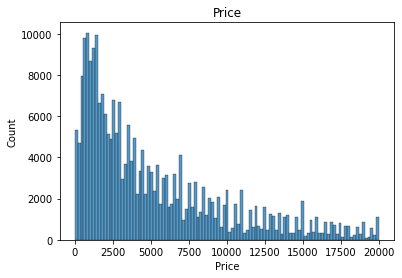

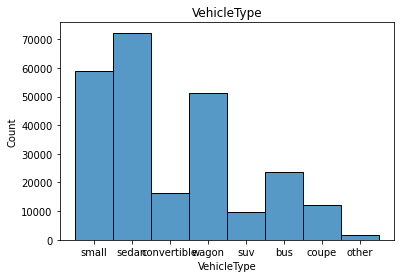

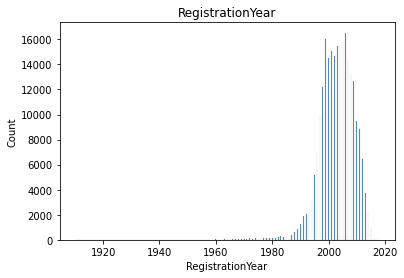

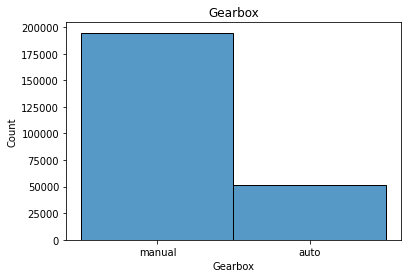

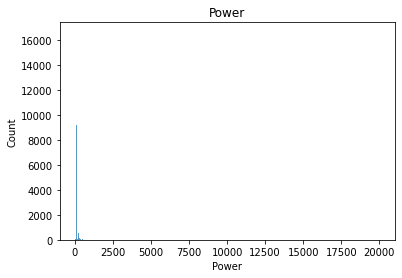

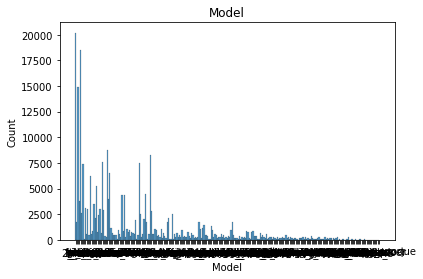

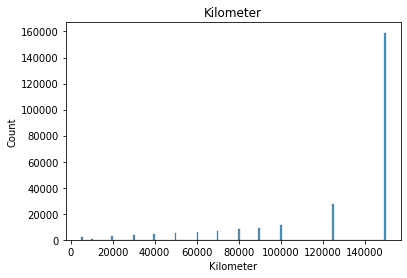

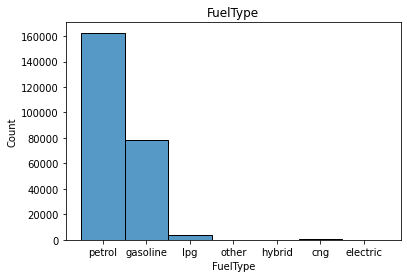

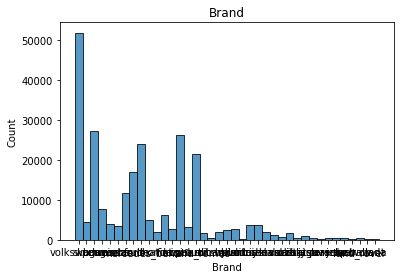

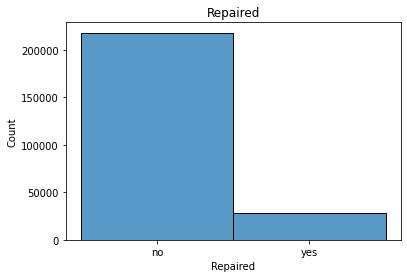

In [9]:
datahist = data_clear.dropna()
for column in datahist.columns:
    plt.figure()
    sns.histplot(datahist[column])
    plt.title(column)

plt.show()

Есть нулевые значения и выбросы. 

In [10]:
data_clear.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

<AxesSubplot:>

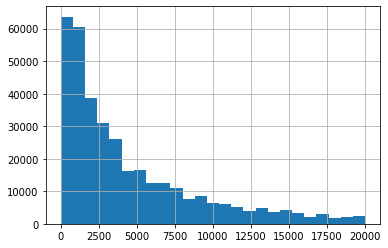

In [11]:
data_clear['Price'].hist(bins=25)

<AxesSubplot:>

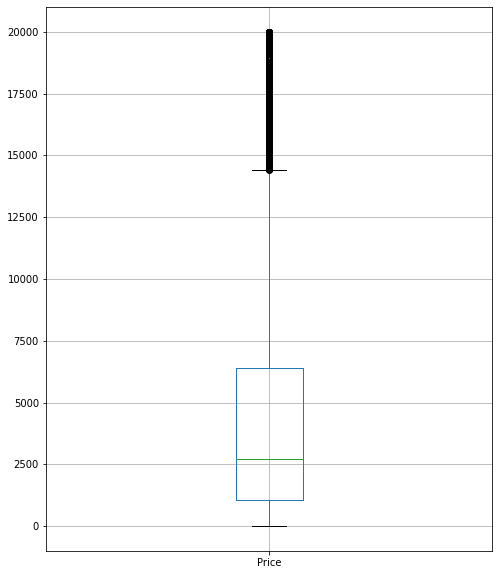

In [12]:
data_clear.boxplot('Price', figsize=(8,10))

In [13]:
sum(data_clear['Price'] < 30)

12267

In [14]:
dataprice = data_clear[data_clear['Price'] < 1000]

Много объявлений около 0

<AxesSubplot:>

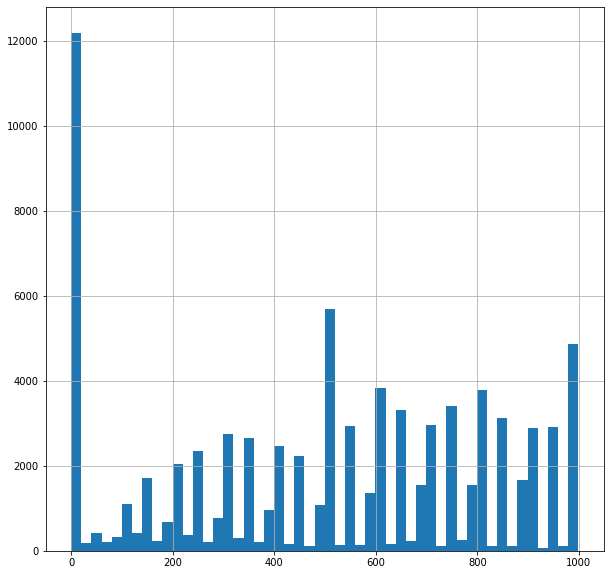

In [15]:
dataprice['Price'].hist(bins=50, figsize=(10,10))

In [16]:
data_clear = data_clear.loc[data_clear['Price'] > 199]

In [17]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336907 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             336907 non-null  int64 
 1   VehicleType       305527 non-null  object
 2   RegistrationYear  336907 non-null  int64 
 3   Gearbox           321352 non-null  object
 4   Power             336907 non-null  int64 
 5   Model             320333 non-null  object
 6   Kilometer         336907 non-null  int64 
 7   FuelType          309693 non-null  object
 8   Brand             336907 non-null  object
 9   Repaired          274462 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.3+ MB


Посмотрим на распределение значений в Repaired

In [18]:
data_clear['Repaired'].fillna('bet', inplace=True)

In [19]:
dataRep = data_clear.loc[data_clear['Repaired'] == 'yes']
datalive = data_clear.loc[data_clear['Repaired'] == 'no']
dataRepNan = data_clear.loc[data_clear['Repaired'] == 'bet']

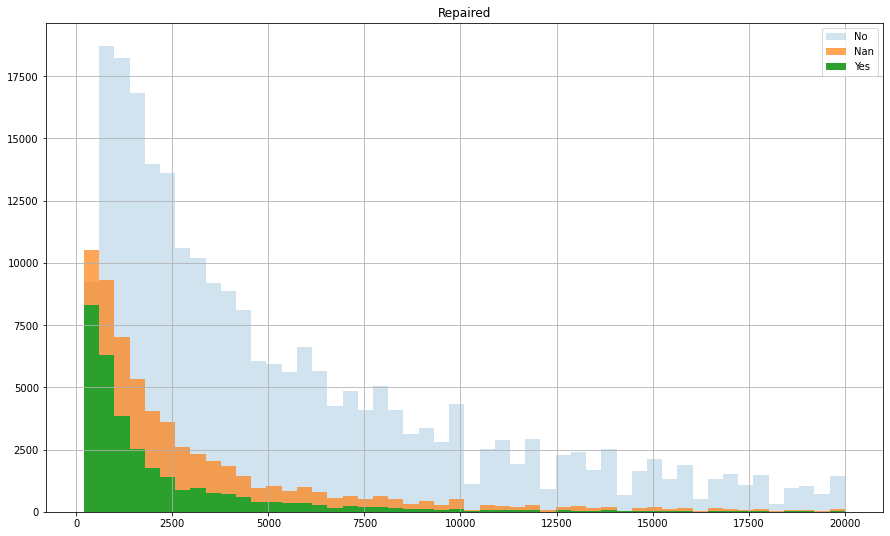

In [20]:
plt.figure(figsize=(15,9))
datalive['Price'].hist(bins=50, label='No', alpha= 0.2)
dataRepNan['Price'].hist(bins=50, label='Nan', alpha= 0.7)
dataRep['Price'].hist(bins=50, label='Yes', alpha= 1)
plt.title('Repaired')
plt.legend()
plt.show()

In [21]:
dataRepNan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62445 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             62445 non-null  int64 
 1   VehicleType       46207 non-null  object
 2   RegistrationYear  62445 non-null  int64 
 3   Gearbox           53346 non-null  object
 4   Power             62445 non-null  int64 
 5   Model             55519 non-null  object
 6   Kilometer         62445 non-null  int64 
 7   FuelType          49835 non-null  object
 8   Brand             62445 non-null  object
 9   Repaired          62445 non-null  object
dtypes: int64(4), object(6)
memory usage: 5.2+ MB


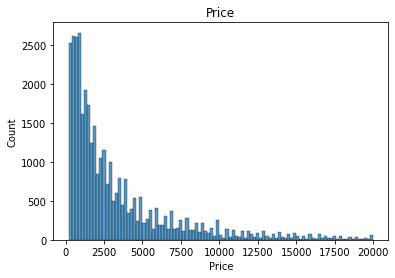

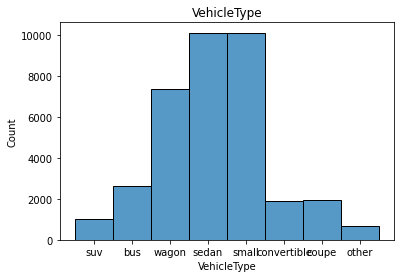

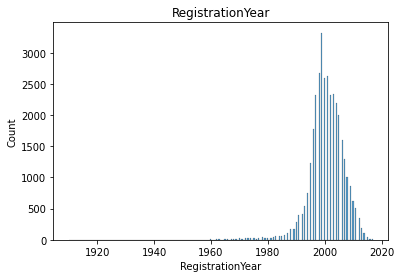

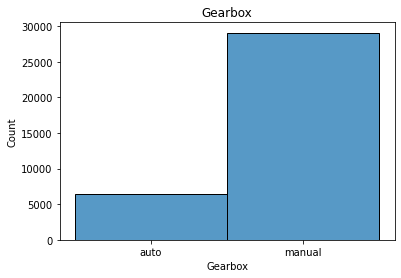

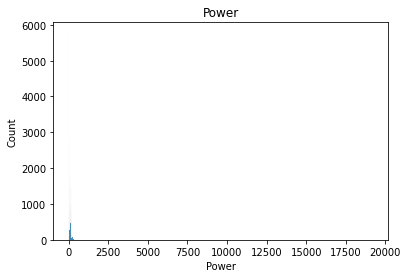

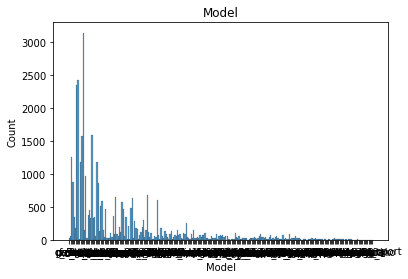

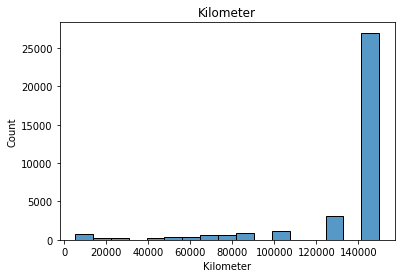

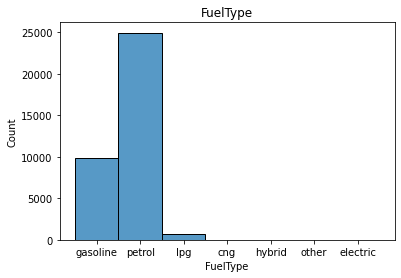

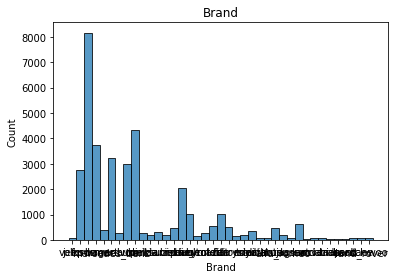

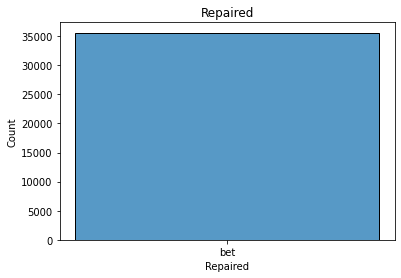

In [22]:
databet = dataRepNan.dropna()
for column in databet.columns:
    plt.figure()
    sns.histplot(databet[column])
    plt.title(column)

plt.show()

В основном объявления с пробегом около 140 тыс.
Думаю мы заменим пропуски в 'Repaired' на yes, так как это не сильно повлияет на распределение. Хотелось бы больше информации, не знаем, что за ремонт и связан ли он как то с дтп. 

In [23]:
data_clear['Repaired'].replace('bet', 'yes', inplace=True)

In [24]:
data_clear['Gearbox'].fillna('other', inplace=True)

In [25]:
datagear = data_clear[data_clear['Gearbox'] == 'other']

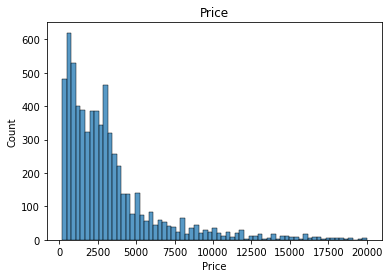

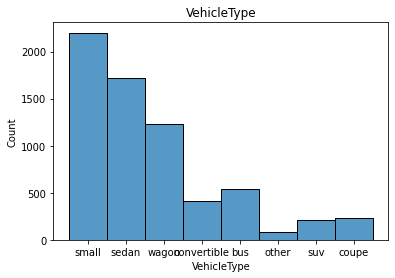

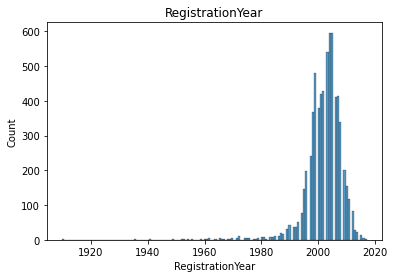

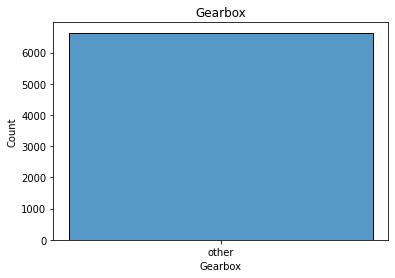

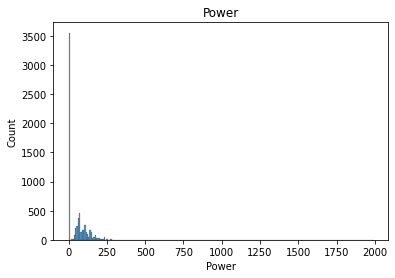

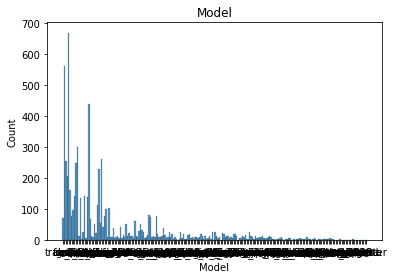

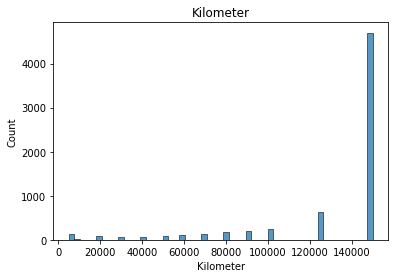

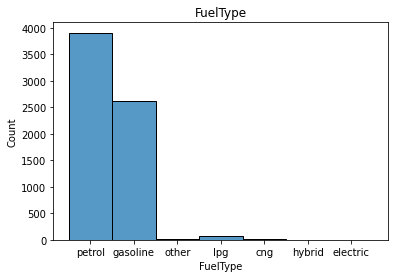

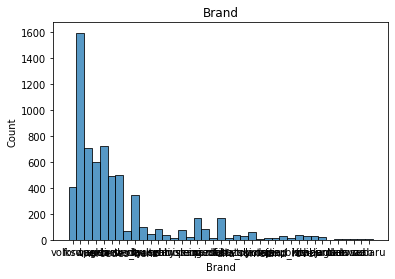

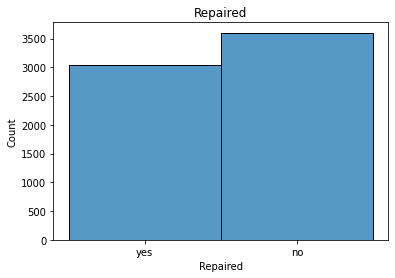

In [26]:
datagear = datagear.dropna()
for column in datagear.columns:
    plt.figure()
    sns.histplot(datagear[column])
    plt.title(column)

plt.show()

Power больше 400 определим как выбросы и удалим.

datagear = datagear.drop(datagear.loc[datagear['Power'] > 400].index)

<AxesSubplot:>

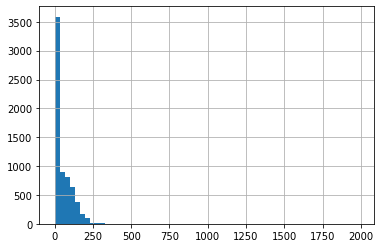

In [27]:
datagear['Power'].hist(bins = 60)


In [28]:
datagear['Power'].unique()

array([   0,   41,  115,   75,  299,   61,  150,  140,   90,   50,   82,
         45,  306,  141,   60,  101,    7,  110,  163,  102,  325,   80,
        136,  144,   54,  184,  107,   58,   71,  131,  170,  105,   73,
        109,   70,  190,  204,  179,   95,  120,  143,  125,  224,   39,
        231,  185,   57,  192,   59,  116,  103,   84,  111,  197,  148,
         85,  124,   44,  213,   55,  193,  218,   83,  145,  320,  232,
        208,   86,   23,  100,  165,   99,  174,  333,  135,  149,   69,
         26,   40,  122,   68,  220,   30,  134,   65,  286,   72,  237,
        200,  155,  156,   64,   88,  114,   92,  805,  126,  272,  118,
        211,   62,   97,  245,  160,  157,  210,  119,   21,  199,   52,
        130,   76,   11,   33,  250,   34,  108,  113,   77,  343,   98,
        177,   25,  129,  180,  159,   29,  106,   74,   66,  147,   81,
         15,   63,  227,   79,   56,   53,  280,  146,  198,  151,  164,
        186,   43,  173,  128,  175,  354,  273,   

пропуски в Gearbox заменим на manual. Power=0 уберем как аномалию

In [29]:
data_clear['Gearbox'].replace('other', 'manual', inplace=True)

In [30]:
data_clear['Power'].sort_values(ascending=False).head(20)

219584    20000
299180    19312
114106    19211
132485    19208
63986     17932
196532    17700
150676    17410
187330    17019
175422    17011
216993    16312
311399    16311
181311    16051
248569    16011
205808    15033
148466    15020
260799    15017
162214    15001
270948    14009
227634    13636
214169    13616
Name: Power, dtype: int64

In [31]:
data_clear = data_clear.drop(data_clear.loc[data_clear['Power'] < 1].index)

In [32]:
data_clear = data_clear.drop(data_clear.loc[data_clear['Power'] > 350].index)

In [33]:
data_clear

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


<AxesSubplot:>

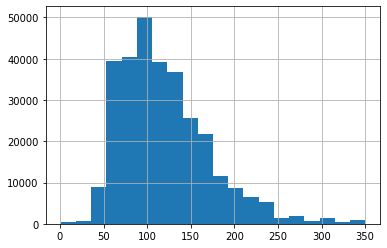

In [34]:
data_clear['Power'].hist(bins=20)

In [35]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302138 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             302138 non-null  int64 
 1   VehicleType       281622 non-null  object
 2   RegistrationYear  302138 non-null  int64 
 3   Gearbox           302138 non-null  object
 4   Power             302138 non-null  int64 
 5   Model             290123 non-null  object
 6   Kilometer         302138 non-null  int64 
 7   FuelType          283236 non-null  object
 8   Brand             302138 non-null  object
 9   Repaired          302138 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.4+ MB


In [36]:
data_clear['Model'].value_counts().head(20)

golf           25643
other          20380
3er            17666
polo           10793
corsa          10107
astra           9290
passat          8958
a4              8919
c_klasse        7421
5er             7165
e_klasse        5925
a3              5534
focus           5217
a6              5009
fiesta          4784
2_reihe         4431
transporter     4221
fortwo          3883
twingo          3780
a_klasse        3593
Name: Model, dtype: int64

Мы выберем наиболее популярный тип модели для каждого бренда и заполним пропущенные значения в столбце 'Model' наиболее популярным значением.

In [37]:
brand_model_counts = data_clear.groupby('Brand')['Model'].value_counts()

In [38]:
most_popular_model = brand_model_counts.groupby('Brand').idxmax().to_dict()

In [39]:
for brand, model_ in most_popular_model.items():
    data_clear.loc[(data_clear['Brand'] == brand) & (data_clear['Model'].isnull()), 'Model'] = model_[1]

In [40]:
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302138 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             302138 non-null  int64 
 1   VehicleType       281622 non-null  object
 2   RegistrationYear  302138 non-null  int64 
 3   Gearbox           302138 non-null  object
 4   Power             302138 non-null  int64 
 5   Model             300300 non-null  object
 6   Kilometer         302138 non-null  int64 
 7   FuelType          283236 non-null  object
 8   Brand             302138 non-null  object
 9   Repaired          302138 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.4+ MB


In [41]:
data_clear.isnull().sum()

Price                   0
VehicleType         20516
RegistrationYear        0
Gearbox                 0
Power                   0
Model                1838
Kilometer               0
FuelType            18902
Brand                   0
Repaired                0
dtype: int64

In [42]:
data_clear['Model'].fillna('other',inplace=True) 

<AxesSubplot:>

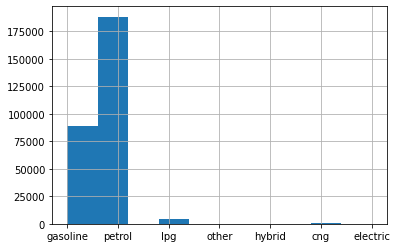

In [43]:
data_clear['FuelType'].hist()

Теперь заполним тип топлива по признаку model

In [44]:
model_fuel_counts = data_clear.groupby('Model')['FuelType'].value_counts()

In [45]:
most_popular_fuel = model_fuel_counts.groupby('Model').idxmax().to_dict()

In [46]:
for model, fuel_ in most_popular_fuel.items():
    data_clear.loc[(data_clear['Model'] == model) & (data_clear['FuelType'].isnull()), 'FuelType'] = fuel_[1]

In [47]:
data_clear.isnull().sum()

Price                   0
VehicleType         20516
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired                0
dtype: int64

<AxesSubplot:>

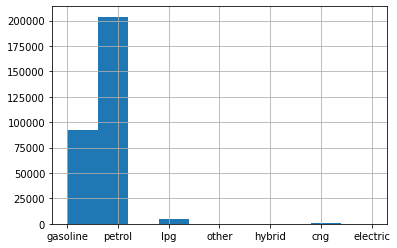

In [48]:
data_clear['FuelType'].hist()

С VehicleType мы сделаем тоже самое

In [49]:
brand_vehicle_counts = data_clear.groupby('Brand')['VehicleType'].value_counts()

In [50]:
most_popular_vehicle = brand_vehicle_counts.groupby('Brand').idxmax().to_dict()

In [51]:
for brand, vehicle_ in most_popular_vehicle.items():
    data_clear.loc[(data_clear['Brand'] == brand) & (data_clear['VehicleType'].isnull()), 'VehicleType'] = vehicle_[1]

In [52]:
data_clear.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [53]:
data_new = data_clear.reset_index(drop=True)

In [54]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302138 entries, 0 to 302137
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             302138 non-null  int64 
 1   VehicleType       302138 non-null  object
 2   RegistrationYear  302138 non-null  int64 
 3   Gearbox           302138 non-null  object
 4   Power             302138 non-null  int64 
 5   Model             302138 non-null  object
 6   Kilometer         302138 non-null  int64 
 7   FuelType          302138 non-null  object
 8   Brand             302138 non-null  object
 9   Repaired          302138 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.1+ MB


In [55]:
data_new['RegistrationYear'].describe()

count    302138.000000
mean       2003.534842
std          29.311948
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Заметили аномалии в RegistrationYear, обрежем хвосты с выбросами

In [56]:
data_new = data_new.drop(data_new.loc[data_new['RegistrationYear'] > 2016].index)

In [57]:
data_new = data_new.drop(data_new.loc[data_new['RegistrationYear'] < 1960].index)

<AxesSubplot:>

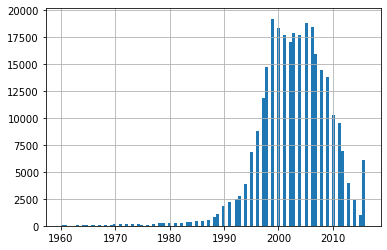

In [58]:
data_new['RegistrationYear'].hist(bins=100)

Дата сет после подготовки:

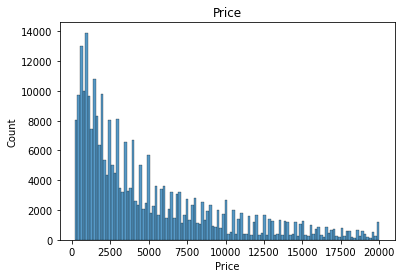

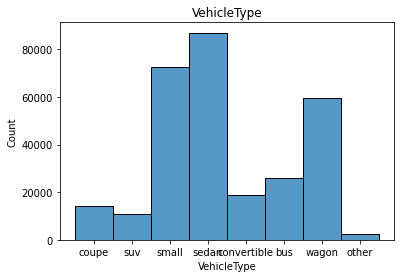

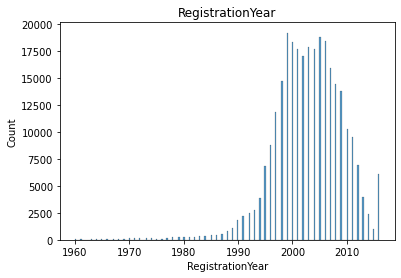

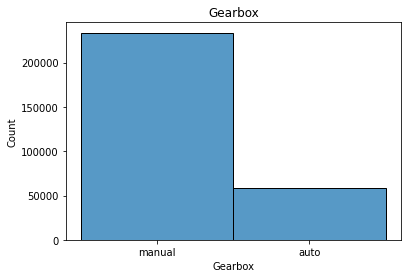

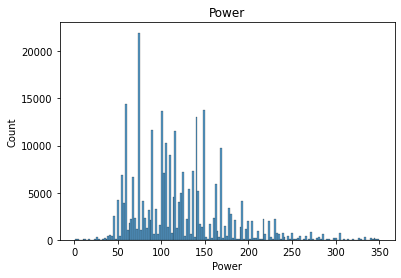

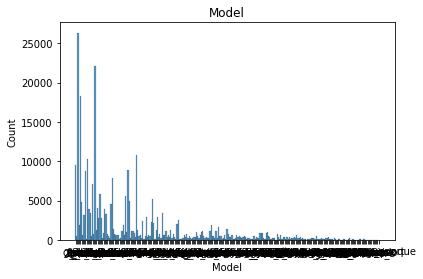

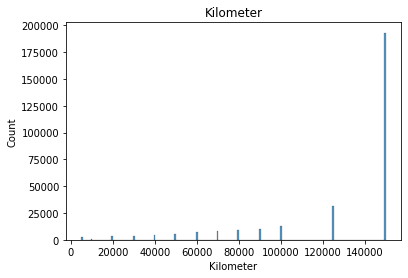

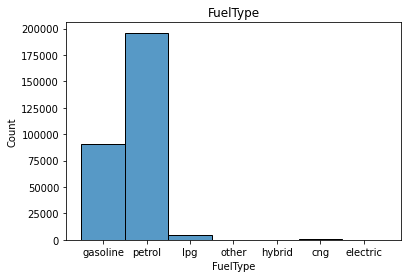

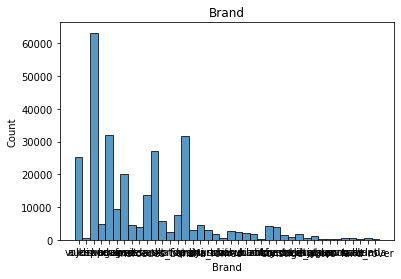

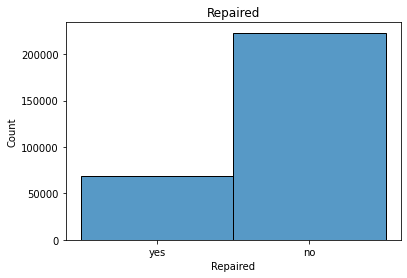

In [59]:
for column in data_new.columns:
    plt.figure()
    sns.histplot(data_new[column])
    plt.title(column)

plt.show()

**Вывод**  
1. Мы изучили таблицу данных.  
2. Выведены аномальные и пропущенные значения.  
3. Отобраны необходимые столбцы для обучения моделей.  
4. Заполнены пропуски в столбцах и удалены некорректные значения.

## Обучение моделей

### CatBoost

In [60]:
data_train, data_test = train_test_split(data_new, test_size=0.4, random_state=322)

In [61]:
features = data_test.drop('Price', axis=1) # признаки
target = data_test['Price'] # целевая переменная

In [62]:
features_valid, features_test, target_valid, target_test = train_test_split(features, target, test_size=0.5, random_state=322)
# затем из части для тестовой выборки выделяем половину для валидоционной выборки

In [63]:
features_train = data_train.drop('Price', axis=1)
target_train = data_train['Price']

In [64]:
# Проверим соотношение данных 
features_train.shape, features_valid.shape, features_test.shape 

((175083, 9), (58361, 9), (58362, 9))

In [65]:
%%time
modelcat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.5,
    depth=10,
    l2_leaf_reg=5,
    bagging_temperature=0.9,
    random_strength=1,
    early_stopping_rounds=20,
    verbose=True,
    loss_function='RMSE',
    random_state=322
)

CPU times: user 85 µs, sys: 5 µs, total: 90 µs
Wall time: 94.4 µs


In [66]:
%%time
modelcat.fit(features_train, target_train, cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])

0:	learn: 3099.3824509	total: 379ms	remaining: 6m 18s
1:	learn: 2384.5717160	total: 700ms	remaining: 5m 49s
2:	learn: 2065.9310387	total: 1.02s	remaining: 5m 38s
3:	learn: 1937.3448159	total: 1.33s	remaining: 5m 30s
4:	learn: 1854.3365698	total: 1.57s	remaining: 5m 12s
5:	learn: 1812.9600134	total: 1.84s	remaining: 5m 4s
6:	learn: 1787.4463523	total: 2.06s	remaining: 4m 52s
7:	learn: 1760.9731441	total: 2.29s	remaining: 4m 44s
8:	learn: 1747.4202048	total: 2.57s	remaining: 4m 42s
9:	learn: 1734.9659683	total: 2.85s	remaining: 4m 42s
10:	learn: 1721.2870964	total: 3.11s	remaining: 4m 39s
11:	learn: 1708.9754963	total: 3.35s	remaining: 4m 36s
12:	learn: 1695.2173658	total: 3.6s	remaining: 4m 33s
13:	learn: 1684.0813288	total: 3.81s	remaining: 4m 28s
14:	learn: 1677.8000824	total: 4.05s	remaining: 4m 25s
15:	learn: 1668.4074427	total: 4.31s	remaining: 4m 25s
16:	learn: 1659.2243851	total: 4.53s	remaining: 4m 21s
17:	learn: 1656.0544593	total: 4.77s	remaining: 4m 20s
18:	learn: 1646.241850

In [67]:
%%time
cat_pred = modelcat.predict(features_valid)

# Оценка качества модели на валидации
mse = mean_squared_error(target_valid, cat_pred)
rmse = np.sqrt(mse)
print('RMSE на валидационных данных:', rmse)

RMSE на тестовых данных: 1571.422427935333
CPU times: user 1.52 s, sys: 15.6 ms, total: 1.54 s
Wall time: 1.55 s


Время fit. : 4min 48s  
Время predict : 1.54 s  
RMSE 1571  
Порог прошла

### LightBM

In [68]:
catlist = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

lgb  не может преобразовать object, так что преобразуем object в category

In [69]:
for feature in catlist:
    features_train[feature] = pd.Series(features_train[feature], dtype="category")

In [70]:
for feature in catlist:
    features_valid[feature] = pd.Series(features_valid[feature], dtype="category")

/tmp/ipykernel_31/3392568829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[feature] = pd.Series(features_valid[feature], dtype="category")


In [71]:
for feature in catlist:
    features_test[feature] = pd.Series(features_test[feature], dtype="category")

/tmp/ipykernel_31/1220871413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[feature] = pd.Series(features_test[feature], dtype="category")


In [ ]:
#for col in catlist:
 #   data[col] = data[col].astype('category')

In [72]:

# Преобразуйте данные в формат Dataset
train_dataset = lgb.Dataset(features_train, label=target_train)
valid_dataset = lgb.Dataset(features_valid, label=target_valid)

# Определите параметры модели
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.50,
    'feature_fraction': 0.9
}

In [73]:
%%time
modellgb = lgb.train(params, train_dataset, num_boost_round=200, valid_sets=[valid_dataset], 
                     early_stopping_rounds=10
                    )

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.403200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 175083, number of used features: 9


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4903.698714
[1]	valid_0's rmse: 3014.96
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 2431.97
[3]	valid_0's rmse: 2179.47
[4]	valid_0's rmse: 1958.22
[5]	valid_0's rmse: 1880.57
[6]	valid_0's rmse: 1828.59
[7]	valid_0's rmse: 1797.91
[8]	valid_0's rmse: 1779.87
[9]	valid_0's rmse: 1758.09
[10]	valid_0's rmse: 1743.13
[11]	valid_0's rmse: 1732.28
[12]	valid_0's rmse: 1720.39
[13]	valid_0's rmse: 1712.39
[14]	valid_0's rmse: 1707.31
[15]	valid_0's rmse: 1701.83
[16]	valid_0's rmse: 1693.21
[17]	valid_0's rmse: 1689.76
[18]	valid_0's rmse: 1686.91
[19]	valid_0's rmse: 1678.81
[20]	valid_0's rmse: 1669.33
[21]	valid_0's rmse: 1665.14
[22]	valid_0's rmse: 1663.22
[23]	valid_0's rmse: 1660.7
[24]	valid_0's rmse: 1659.63
[25]	valid_0's rmse: 1658.38
[26]	valid_0's rmse: 1654.35
[27]	valid_0's rmse: 1653.24
[28]	valid_0's rmse: 1652.41
[29]	valid_0's rmse: 1651.88
[30]	valid_0's rmse: 1651.85
[31]	valid_0's rmse: 16

In [74]:
%%time
predictions = modellgb.predict(features_valid)

mse = mean_squared_error(target_valid, predictions)
rmse = np.sqrt(mse)
print('RMSE на валидационных данных:', rmse)

RMSE на тестовых данных: 1579.341143317113
CPU times: user 753 ms, sys: 6.85 ms, total: 760 ms
Wall time: 720 ms


Время fit. : 10min 4s  
Время predict : 760 ms  
RMSE 1579  
Порог прошла.

### Линейная регрессия

In [91]:
data_OHE = pd.get_dummies(data_new,drop_first=True, columns=catlist)

In [92]:
data_trainOHE, data_testOHE = train_test_split(data_OHE, test_size=0.4, random_state=322)

In [93]:
featuresOHE = data_testOHE.drop('Price', axis=1) # признаки
targetOHE = data_testOHE['Price'] # целевая переменная

In [94]:
features_validOHE, features_testOHE, target_validOHE, target_testOHE = train_test_split(featuresOHE,
                                                                                        targetOHE,
                                                                                        test_size=0.5,
                                                                                        random_state=322
                                                                                       )
# затем из части для тестовой выборки выделяем половину для валидоционной выборки

In [95]:
features_trainOHE = data_trainOHE.drop('Price', axis=1)
target_trainOHE = data_trainOHE['Price']

In [96]:
print(features_trainOHE.shape)
print(features_validOHE.shape)
print(features_testOHE.shape)

(175083, 305)
(58361, 305)
(58362, 305)


In [97]:
%%time
linmodel = LinearRegression()
linmodel.fit(features_trainOHE, target_trainOHE)

CPU times: user 11.3 s, sys: 5.04 s, total: 16.3 s
Wall time: 16.3 s


LinearRegression()

In [98]:
%%time
preds_linmodel = linmodel.predict(features_validOHE)

CPU times: user 136 ms, sys: 97.8 ms, total: 234 ms
Wall time: 195 ms


In [99]:
mse = mean_squared_error(target_validOHE, preds_linmodel)
rmse = np.sqrt(mse)
print('RMSE на валидационных данных:', rmse)

RMSE на валидационных данных: 2574.5316614952226


Время fit. : 16.3 s  
Время predict : 234 ms  
RMSE 2575  
Порог не прошла.

### Вывод  
Catboost и lightGB прошли порог по рмсе в 1600, линейная регрессия порог не преодолела. Catboost оказался точнее и быстрее lightGB. Проверку на тесте пройдет Catboost.

## Анализ моделей

In [82]:
%%time
cat_pred_test = modelcat.predict(features_test)

# Оценка качества модели на валидации
mse = mean_squared_error(target_test, cat_pred_test)
rmse = np.sqrt(mse)
print('RMSE на тестовых данных:', rmse)

RMSE на тестовых данных: 1560.6696252166266
CPU times: user 1.24 s, sys: 4.66 ms, total: 1.25 s
Wall time: 1.25 s


Результаты Catboost на тестовой выборке: time predict : 1.25 s, RMSE 1560.  
Порог в 1600 преодолен. 

In [84]:
feature_importances = modelcat.feature_importances_
display(feature_importances)

array([ 8.61762567, 31.85413453,  1.28319957, 22.36515133,  6.74315832,
       11.32651152,  3.32887827, 11.67355278,  2.80778801])

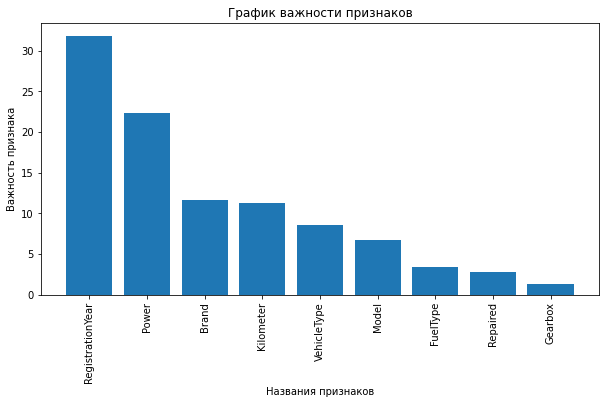

In [87]:
# Построение графика важности признаков
feature_names = features.columns
feature_importance_df = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by=['feature_importance'], ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(feature_importance_df['feature_names'], feature_importance_df['feature_importance'])
plt.xticks(rotation=90)
plt.xlabel('Названия признаков')
plt.ylabel('Важность признака')
plt.title('График важности признаков')
plt.show()

**Вывод** На тестовой выборке Catboost прошел порог и показал результат 1560 RMSE за 1.25 s. 

## Итоги

Мы в ходе проекта: загрузили данные и провели предобработку. Сравнили модели catboost, lgbm и linerReg.  
Лучший результат на валидационной выборке показал Catboost.  
На тестовой выборке результаты Catboost:  
time fit - 4min 48s  
time predict - 1.25 s  
RMSE - 1560  
Наибольшее значение в формировании цены играет год выпуска. Наименьшее значение у коробки передач. 